<a href="https://colab.research.google.com/github/HongJaeKwon/kimhae_fire_detection/blob/master/hjk_fire_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
# /gdrive/My Drive/ (폴더명)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import numpy as np
import pandas as pd
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from  sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import losses
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.layers import Conv2D, Conv2DTranspose, Activation, Flatten, Dense, UpSampling2D, Reshape, Lambda, Input,BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, Iterator
from tensorflow.python.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.python.keras.losses import mean_absolute_error
warnings.filterwarnings(action='ignore') 
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def hjk_loss(y_true,y_pred):
    bce = 3*y_true * K.log(y_pred + K.epsilon())
    bce += (1 - y_true) * K.log(1 - y_pred + K.epsilon())
    return -bce

def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = K.clip(f1,K.epsilon(),1-K.epsilon())
    return 1 - K.mean(f1)   

In [0]:
def build_encoder():
    model=Sequential()
    model.add(Dense(32*32,activation='relu',input_shape=(436,)))
    model.add(Reshape((32,32,1)))
    model.add(Conv2D(2, 3, activation='elu', strides=2, padding='same'))
    model.add(Conv2D(4, 3, activation='elu', strides=2, padding='same'))
    model.add(Conv2D(8, 3, activation='elu', strides=2, padding='same'))
    return model

def build_decoder():
    model=Sequential()
    model.add(Conv2D(4, 3, activation='elu', padding='same'))
    model.add(UpSampling2D())
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(2, 3, activation='elu', padding='same'))
    model.add(UpSampling2D())
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(1, 3, activation='elu', padding='same'))
    model.add(UpSampling2D())
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(436,activation='sigmoid'))
    return model

In [0]:
all_DF= pd.read_csv('/gdrive/My Drive/김해화재/all_DF.csv',index_col=0)
# train :59199
# val : 6898
# test : 2957

In [0]:
train_DF=all_DF[:59199]
val_DF=all_DF[59199:59199+6898]
test_DF=all_DF[all_DF['LABEL']==-1]

train_DF_Y=train_DF['LABEL']
val_DF_Y=val_DF['LABEL']
train_DF_normal=train_DF[train_DF['LABEL']==0]
train_DF_fire=train_DF[train_DF['LABEL']==1]

train_DF=train_DF.drop('LABEL', axis = 1)
val_DF=val_DF.drop('LABEL', axis = 1)
test_DF=test_DF.drop('LABEL', axis = 1)

train_DF_normal=train_DF_normal.drop('LABEL', axis = 1)
train_DF_fire=train_DF_fire.drop('LABEL', axis = 1)

train_DF_1=train_DF[:30000]
train_DF_Y_1=train_DF_Y[:30000]
train_DF_2=train_DF[30000:]
train_DF_Y_2=train_DF_Y[30000:]

col_list=train_DF.columns.to_list()

In [0]:
encoder = build_encoder()
decoder = build_decoder()
AE_model=Sequential((encoder, decoder))
AE_model.compile(loss='mse',optimizer=Adam(0.001))
fire_inputs = Input((436,))
non_fire_inputs = Input((436,))
fire_outputs = AE_model(fire_inputs)
non_fire_outputs = AE_model(non_fire_inputs)

AE_trainer=Model(inputs=[fire_inputs, non_fire_inputs],outputs=[fire_outputs, non_fire_outputs])
AE_trainer.compile(loss=['mse', 'mse'], loss_weights=[1., -1.0], optimizer=Adam(0.001))

def AE_train(fire,non_fire,epochs = 10, batch_size=16):
    batch_count =fire.shape[0]//batch_size
        
    for e in range(1, epochs+1):
        for _ in tqdm(range(batch_count)):
            fire_batch = fire[np.random.randint(0, fire.shape[0], size=batch_size)]
            non_fire_batch = non_fire[np.random.randint(0, non_fire.shape[0], size=batch_size)]
            _,fire_loss, non_fire_loss = AE_trainer.train_on_batch([fire_batch, non_fire_batch], [fire_batch, non_fire_batch])
        print("")
        print("fire_loss", fire_loss)
        print("non_fire_loss", non_fire_loss)

In [0]:
AE_train(train_DF_fire.as_matrix(),train_DF_normal.as_matrix(),epochs=50)

In [0]:
fire=encoder.predict(train_DF_fire.as_matrix())
non_fire=encoder.predict(train_DF_normal.as_matrix())

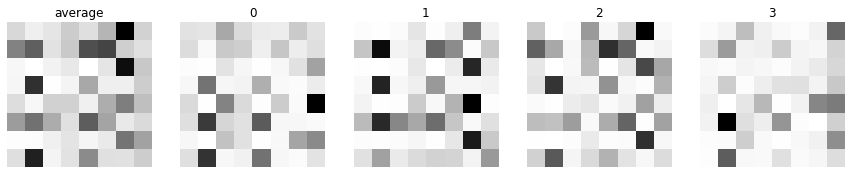

In [93]:
fig = plt.figure(figsize=(15,6))
rows = 1
cols = 5
fire=np.reshape(fire,(-1,8,8,1))
fire_batch = fire[np.random.randint(0, fire.shape[0], size=4)]

resize_image = array_to_img(fire.mean(0)).resize((80,80))
ax = fig.add_subplot(rows, cols,1)
ax.imshow(resize_image,cmap='Greys')
ax.set_title('average')
ax.axis("off") 

for i in range(cols-1):
    resize_image = array_to_img(fire_batch[i]).resize((80,80))
    ax = fig.add_subplot(rows, cols, i+2)
    ax.imshow(resize_image,cmap='Greys')
    ax.set_title(str(i))
    ax.axis("off")    

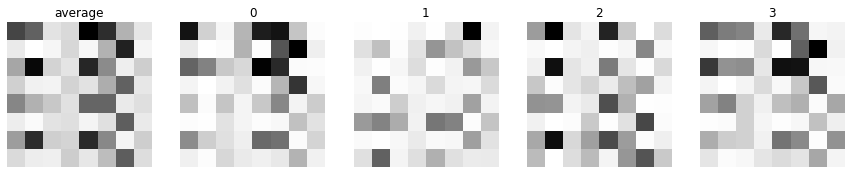

In [94]:
fig = plt.figure(figsize=(15,6))
rows = 1
cols = 5
non_fire=np.reshape(non_fire,(-1,8,8,1))
non_fire_batch = non_fire[np.random.randint(0, non_fire.shape[0], size=4)]

resize_image = array_to_img(non_fire.mean(0)).resize((80,80))
ax = fig.add_subplot(rows, cols,1)
ax.imshow(resize_image,cmap='Greys')
ax.set_title('average')
ax.axis("off") 

for i in range(cols-1):
    resize_image = array_to_img(non_fire_batch[i]).resize((80,80))
    ax = fig.add_subplot(rows, cols, i+2)
    ax.imshow(resize_image,cmap='Greys')
    ax.set_title(str(i))
    ax.axis("off")   

In [84]:
fire=np.reshape(fire,(-1,64))
non_fire=np.reshape(non_fire,(-1,64))
for i in range(32):
    print(i)
    print("fire 평균",np.mean(fire[:,i]))
    print("fire 편차",np.std(fire[:,i]))
    print("non-fire 평균",np.mean(non_fire[:,i]))
    print("non-fire 편차",np.std(non_fire[:,i]))
    print()

0
fire 평균 -0.016376752
fire 편차 1.1104034
non-fire 평균 1.4390091
non-fire 편차 1.3939914

1
fire 평균 -0.25282434
fire 편차 1.2465001
non-fire 평균 1.200783
non-fire 편차 2.2751598

2
fire 평균 -0.14732201
fire 편차 0.81389135
non-fire 평균 -0.11689751
non-fire 편차 0.69184804

3
fire 평균 0.08842026
fire 편차 0.53669703
non-fire 평균 0.029029725
non-fire 편차 0.54035074

4
fire 평균 -0.08585814
fire 편차 1.2573465
non-fire 평균 2.0076942
non-fire 편차 1.9634624

5
fire 평균 0.27162948
fire 편차 1.1488984
non-fire 평균 1.6217449
non-fire 편차 1.5288312

6
fire 평균 1.4494922
fire 편차 2.009224
non-fire 평균 0.4493365
non-fire 편차 1.6801482

7
fire 평균 0.038995113
fire 편차 0.9431668
non-fire 평균 -0.15505147
non-fire 편차 0.8032179

8
fire 평균 0.6070339
fire 편차 0.85348815
non-fire 평균 -0.2170983
non-fire 편차 0.7040354

9
fire 평균 0.86075455
fire 편차 2.0698867
non-fire 평균 -0.62952566
non-fire 편차 1.0016288

10
fire 평균 -0.12624584
fire 편차 0.8288101
non-fire 평균 -0.42405707
non-fire 편차 0.54920596

11
fire 평균 0.110202916
fire 편차 0.4900909
non-fire 평균 0.

In [0]:
cnn_model=Sequential()
cnn_model.add(Dense(16*16,activation='relu',input_shape=(436,)))
cnn_model.add(Reshape((16,16,1)))
cnn_model.add(Conv2D(2, 3, activation='elu', strides=2, padding='same'))
cnn_model.add(Conv2D(4, 3, activation='elu', strides=2, padding='same'))
cnn_model.add(Conv2D(8, 3, activation='elu', strides=2, padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(1,activation='sigmoid'))
cnn_model.compile(loss=hjk_loss, metrics=['acc',f1_m, precision_m, recall_m],optimizer=Adam(0.001))

In [0]:
new_train_DF=AE_model.predict(train_DF.as_matrix())
new_val_DF=AE_model.predict(val_DF.as_matrix())
new_test_DF=AE_model.predict(test_DF.as_matrix())

In [87]:
cnn_model.fit(new_train_DF,train_DF_Y.as_matrix(),epochs=30,validation_split=0.2)

Train on 47359 samples, validate on 11840 samples
Epoch 1/30
47359/47359 [==============================] - 8s 169us/sample - loss: 0.4731 - acc: 0.8353 - f1_m: 0.5069 - precision_m: 0.3958 - recall_m: 0.7971 - val_loss: 0.6381 - val_acc: 0.7328 - val_f1_m: 0.5499 - val_precision_m: 0.4082 - val_recall_m: 0.9127
Epoch 2/30
47359/47359 [==============================] - 8s 159us/sample - loss: 0.4649 - acc: 0.8397 - f1_m: 0.5043 - precision_m: 0.3992 - recall_m: 0.7782 - val_loss: 0.6308 - val_acc: 0.7391 - val_f1_m: 0.5465 - val_precision_m: 0.4104 - val_recall_m: 0.8870
Epoch 3/30
47359/47359 [==============================] - 7s 155us/sample - loss: 0.4615 - acc: 0.8361 - f1_m: 0.5070 - precision_m: 0.3964 - recall_m: 0.7981 - val_loss: 0.6251 - val_acc: 0.7392 - val_f1_m: 0.5529 - val_precision_m: 0.4125 - val_recall_m: 0.8995
Epoch 4/30
47359/47359 [==============================] - 7s 158us/sample - loss: 0.4603 - acc: 0.8367 - f1_m: 0.5097 - precision_m: 0.3973 - recall_m: 0.8034

In [88]:
cnn_model.evaluate(new_val_DF,val_DF_Y.as_matrix())

6898/6898 [==============================] - 1s 74us/sample - loss: 0.9192 - acc: 0.5918 - f1_m: 0.4092 - precision_m: 0.2842 - recall_m: 0.8062


[0.919243024722083, 0.5917657, 0.40920284, 0.2842357, 0.8062429]

In [0]:
y_pred=np.round(cnn_model.predict(new_test_DF))

In [0]:
sub = pd.read_csv('/gdrive/My Drive/김해화재/PJT002_submission.csv')
sub['fr_yn'] = y_pred
sub['fr_yn'] = sub['fr_yn'].map({0:'N', 1:'Y'})
sub.to_csv('/gdrive/My Drive/김해화재/PJT002_submission_hjk_AE1.csv', index=False)